# 음악 추천 서비스(데이터 분석과 예측모델)

이 프로젝트의 목적은 Kaggle의 'WSDM - KKBox's Music Recommendation Challenge' 대회에서 제공하는 데이터를 통한 데이터 분석 및 예측모델 구성 입니다

이 프로젝트는 다음과 같은 데이터 work-flow 를 따릅니다.
1. Data Preprocessing & Exploratory Data Analysis (데이터 선처리 및 분석)
2. Feature Engineering & Creating Input Data Set (변수 변환 및 모델 입력 데이터 세트 만들기)
3. Building Prediction Model (예측모델 만들기)
4. Feedback (전체 프로젝트에 대한 피드백 및 수정)


## Kaggle 데이터 해설

**Kaggle 데이터 URL: https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data**

In this task, you will be asked to predict the chances of a user listening to a song repetitively after the first observable listening event within a time window was triggered. If there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, its target is marked 1, and 0 otherwise in the training set. The same rule applies to the testing set.

KKBOX provides a training data set consists of information of the first observable listening event for each unique user-song pair within a specific time duration. Metadata of each unique user and song pair is also provided. The use of public data to increase the level of accuracy of your prediction is encouraged.

The train and the test data are selected from users listening history in a given time period. Note that this time period is chosen to be before the WSDM-KKBox Churn Prediction time period. The train and test sets are split based on time, and the split of public/private are based on unique user/song pairs.


**train.csv**

- msno: user id
- song_id: song id
- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
- source_screen_name: name of the layout a user sees.
- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

**test.csv**

- id: row id (will be used for submission)
- msno: user id
- song_id: song id
- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
- source_screen_name: name of the layout a user sees.
- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.

**sample_submission.csv**

sample submission file in the format that we expect you to submit

- id: same as id in test.csv
- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

**songs.csv**

The songs. Note that data is in unicode.

- song_id
- song_length: in ms
- genre_ids: genre category. Some songs have multiple genres and they are separated by |
- artist_name
- composer
- lyricist
- language

**members.csv**

user information.

- msno
- city
- bd: age. Note: this column has outlier values, please use your judgement.
- gender
- registered_via: registration method
- registration_init_time: format %Y%m%d
- expiration_date: format %Y%m%d

**song_extra_info.csv**

- song_id
- song name - the name of the song.
- isrc - International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

## Data Preprocessing & Exploratory Data Analysis (데이터 선처리 및 분석)

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.float64,
                                                  'song_id' : 'category'})
test = pd.read_csv('test.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})
songs = pd.read_csv('songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv('members.csv',dtype={'city' : 'category',
                                                      'bd' : np.float64,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv('song_extra_info.csv')

In [32]:
train.isnull().sum()

msno                       0
song_id                    0
source_system_tab      18371
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

각각의 변수들이 가지는 null값이 몇개나 있는지 확인해 보았습니다. train 데이터 세트에 73만개의 데이터가 6가지 변수를 가지고 있는것을 볼 수 있습니다. 이 변수들 중 source_screen_name, source_type, source_system_tab 순으로 null값이 많습니다

In [33]:
for x in train.columns:
    print('number of unique values(%s)' % x, len(set(train[x])))

number of unique values(msno) 30755
number of unique values(song_id) 359966
number of unique values(source_system_tab) 10
number of unique values(source_screen_name) 21
number of unique values(source_type) 13
number of unique values(target) 2


각 변수들이 몇 개의 중첩되지 않는 값들을 가지고 있는지 확인해 보았습니다. 중첩되지 않는 값들의 갯수를 보았을 떄, source_system_tab, source_screen_name,source_type, target 변수들이 확실히 카테고리 변수 라는것을 알 수 있었습니다

msno(유저 아이디) 와 song_id(음악 고유번호)의 중첩되지 않는 값의 갯수를 train 데이터 세트 값들의 총 갯수(73만개)와 비교해 보면,  평균적으로 각각 24번(73만 / 30755), 2번(73만 / 359966)정도로 각 변수들의 값이 반복되어 train 데이터 세트에 나타난다는 것을 알 수 있습니다

target 변수의 경우, target 변수가 예측모델의 Y 변수 (얘측 해야 되는 변수/값)입니다

### 1. train 데이터 세트의 msno 변수에 대한 분석

In [34]:
msno_groupby_train = train.groupby(['msno']).size().sort_values(ascending=False)
msno_groupby_test = test.groupby(['msno']).size().sort_values(ascending=False)

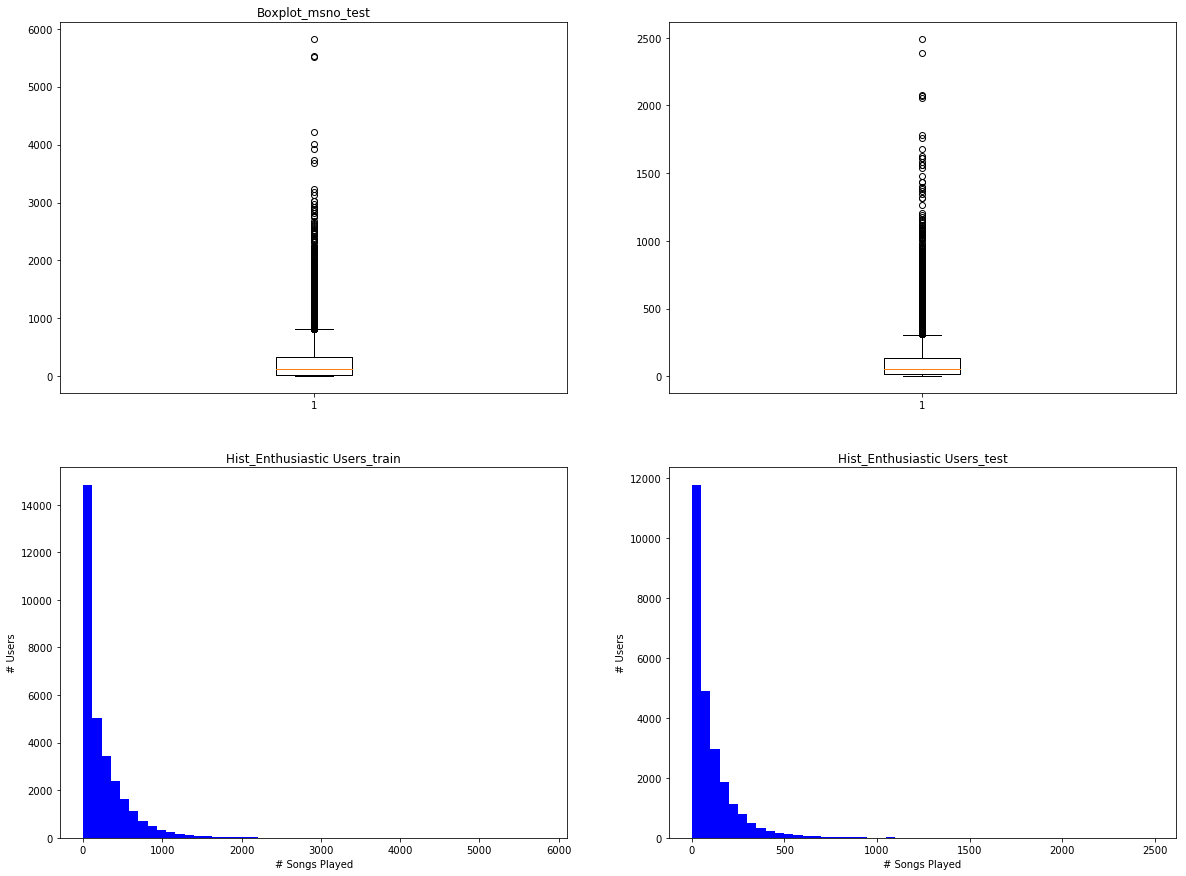

In [35]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 15))

axes[0, 0].boxplot(msno_groupby_train.values)
axes[0, 1].boxplot(msno_groupby_test.values)
axes[0, 0].set(title = 'Boxplot_msno_train')
axes[0, 0].set(title = 'Boxplot_msno_test')

axes[1, 0].hist(msno_groupby_train, 50, facecolor='b')
axes[1, 1].hist(msno_groupby_test, 50, facecolor='b')
axes[1, 0].set(xlabel = '# Songs Played', ylabel = '# Users', title = 'Hist_Enthusiastic Users_train')
axes[1, 1].set(xlabel = '# Songs Played', ylabel = '# Users', title = 'Hist_Enthusiastic Users_test')


plt.show()

Box plot 과 histogram 그래프에 의하면, 데이터 세트 대부분의 고객들은 음악을 1번에서 1000번 가까이 듣는 것으로 나타났으나, 1000번 이상 노래를 듣는 헤비유저들이 다수 데이터에 포함 되어 있는 것 들을 알 수 있습니다. 이 경우, 아웃라이어로 보기에는 1000번 이상 노래를 듣는 고객들이 너무 많기에 나중에 예측모델의 input값으로 쓸 경우 standardization을 해야 한다는 것을 알수 있고, 또 이러한 헤비유저들을 대상으로 데이터를 분석 할 시 흥미로운 결과를 볼 수 있을 것이라 예상 합니다.

train 세트와 test 세트를 비교해 보면, train 세트의 boxplot 데이터 범위가 0~6000 이고 test 세트의 데이터의 범위가 0~2500인걸로 비추어 보아, test 세트가 비교적 덜 기울어진 데이터 분포를 가지고 있고, 더욱 0에 집중된 데이터를 가지고 있다는 것을 알 수 있습니다

In [40]:
msno_group_by = msno_groupby_train.reset_index()
msno_group_by.columns = ['msno', '#listened']
train_copy = train.copy()
train_msno_frequency = pd.merge(train_copy, msno_group_by, on='msno')
train_msno_frequency = train_msno_frequency.groupby(['#listened']).agg(['mean', 'count'])
train_msno_frequency = train_msno_frequency.reset_index()
train_msno_frequency.columns = ['#listened', 'mean', 'count']
train_msno_frequency.head()

,#listened,mean,count
0,1,0.162017,932
1,2,0.164394,1320
2,3,0.129630,1674
3,4,0.212069,1740
4,5,0.176847,2030


In [37]:
train.groupby('target').size()

target
0.0    3662762
1.0    3714656
dtype: int64

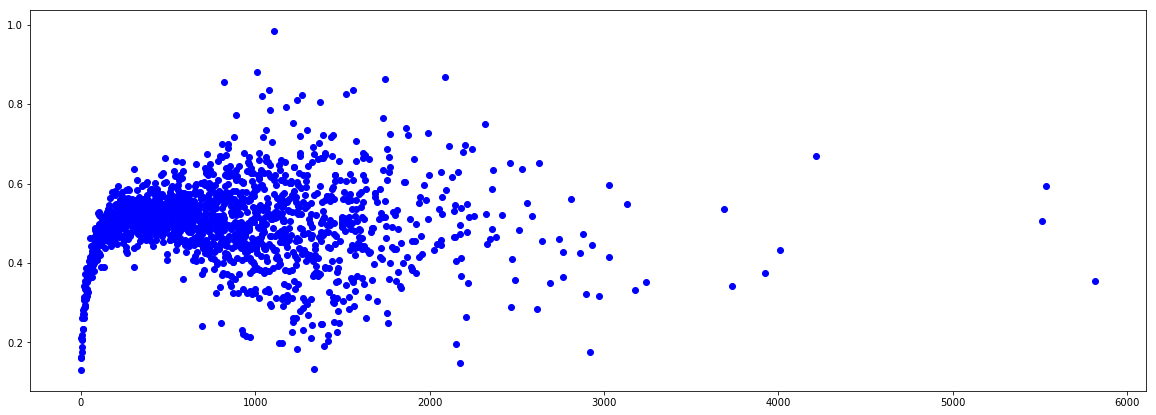

In [41]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.scatter(x = train_msno_frequency['#listened'], y = train_msno_frequency['mean'], c='b')
plt.show()

train 데이터 세트의 'target' 변수를 보면, 0 과 1이 각각 데이터의 50%를 차지 하는 것을 알 수 있습니다. 여기에 더해 아래의 '#listened'변수(각각 한 명의 고객이 몇 가지 노래를 들었는가)과 'target'변수의 상관 관계를 scatter plot으로 보면, '#listened'의 값이 늘어나는 것과 상관없이 0 과 1 값이 고르게 분포하는 것을 알 수 있습니다 

In [45]:
def target_mean_on_frequency_graph(df, var, nrow, ncol, figsize):
    fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = figsize)
    df1 = df[[var, 'target']].groupby([var]).agg(['mean', 'count'])
    df2 = df1.reset_index()
    df2.columns = [var, 'mean', 'count']
    df2['repeat'] = df2['mean']*df2['count']

    x = []
    y = []
    for i in range(1,df2['count'].max()+1):
        plays_i = df2[df2['count']==i]
        count = plays_i['count'].sum()
        if count > 0:
            x.append(i)
            y.append(plays_i['repeat'].sum() / count)
    plt.scatter(x, y)
    plt.show()

한 사람이 몇 개 의 노래를 들었는지(x 값)와 target 의 평균값(y 값) 사이의 관계를 그래프로 표시해 보면, 0부터 200 사이의 x값과 y값은 긍정적인 상관관계를 보이나, 그 이후로는 변동성이 너무 커서 상관관계를 찾아보기 어렵다는 것을 알 수 있습니다.

### 2. train 데이터 와 song 데이터 세트를 통한 분석

In [47]:
songs_merge = pd.merge(songs, songs_extra, on = 'song_id')
pd.to_pickle(songs_merge, 'songs_merge')

In [48]:
songs_merge.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情,TWB531410010
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE,NaN
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY,NaN
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,愛我的資格,TWC950206108
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,Mary Had a Little Lamb,NaN


In [ ]:
train_songs = pd.merge(train, songs_merge, on ='song_id')
pd.to_pickle(train_songs, 'train_songs')
train_songs = pd.read_pickle('train_songs')

In [51]:
def reset_mean_count(df, x):
    df = df[[x, 'target']].groupby([x]).agg(['mean', 'count'])
    df = df.reset_index()
    df.columns = [x, 'mean', 'count']
    return df

In [52]:
train_songs_repeat = train_songs[['song_id', 'target']].groupby(['song_id']).agg(['mean', 'count'])

In [53]:
train_songs_songid = reset_mean_count(train_songs, 'song_id')
train_songs_length = reset_mean_count(train_songs, 'song_length')
train_songs_genre = reset_mean_count(train_songs, 'genre_ids')
train_songs_artist = reset_mean_count(train_songs, 'artist_name')
train_songs_composer = reset_mean_count(train_songs, 'composer')
train_songs_lyricist = reset_mean_count(train_songs, 'lyricist')
train_songs_language = reset_mean_count(train_songs, 'language')

In [54]:
lis = [train_songs_songid ,train_songs_length ,train_songs_genre, train_songs_artist ,train_songs_composer 
       ,train_songs_lyricist ,train_songs_language]
lis1 = ['song_id', 'song_length', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'language']

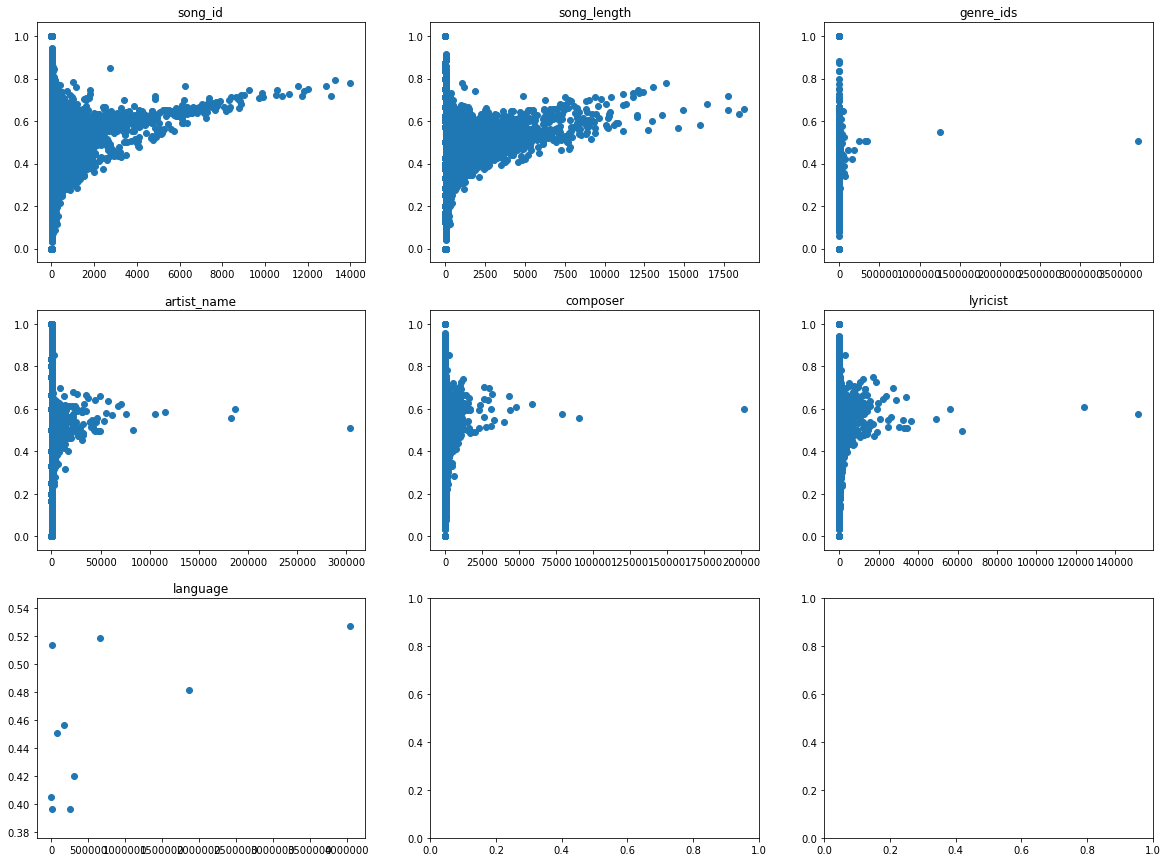

In [55]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(20, 15))

for ax, name, col in zip(axes.flat, lis1, lis):
    x = col.iloc[:,2].values
    y = col.iloc[:,1].values
    ax.scatter(x, y)
    ax.set(title=name)
plt.show()

위의 그래프는 변수에 있는 값들이 얼마나 중복되어 데이터 세트에 포함되어 있는가를 x 값으로, 그 각 값들이 가지는 평균 target 값을 y로 하여 나타냅니다. 

1. song_id 의 경우 몇 명의 고객에게 노래가 플레이 되었는지- 즉 대중성 -  (x)에 따라 평균 적으로 고객이 그 노래를 다시 들을지에 대한 값 (y) 가 늘어나는 것을 알 수 있습니다
2. song_length의 경우, 평균적인 플레이 타임을 가질수록 고객들이 다시 들을 확율 (y)가 늘어나느 것 을 알 수 있습니다
3. genre_ids, artist_name, composer, lyricist의 경우, 각 변수들의 대중성과 다시들을 확율 사이에 별다른 관계가 없다는 것을 알 수 있습니다. 아마도 각 변수들의 값을 카테고리 변수로 적용하여 데이터 분석을 해 보하야 한다고 생각 합니다
4. language의 경우 언어 자체의 대중성 보다는 각 언어별로 다시들을 확율이 다르기에 카테고리 변수르 예측 모델에 쓰는 것이 더 알맞다는 것을 알 수 있습니다.

In [56]:
def count_vals(x):
    if type(x) != str:
        return 1
    else:
        return 1 + x.count('|')

In [57]:
train_songs_copy = train_songs.copy()
train_songs_copy['number_of_genres'] = train_songs_copy['genre_ids'].apply(count_vals)
train_songs_copy['number_of_composers'] = train_songs_copy['composer'].apply(count_vals)
train_songs_copy['number_of_lyricists'] = train_songs_copy['lyricist'].apply(count_vals)

In [58]:
lis = ['number_of_genres', 'number_of_composers', 'number_of_lyricists']
for x in lis:
    print(x, 'more than 5:', len(train_songs_copy[train_songs_copy[x]>5]))
    print(x, 'more than 10', len(train_songs_copy[train_songs_copy[x]>10]))
    print(x, 'more than 20:', len(train_songs_copy[train_songs_copy[x]>20]))

number_of_genres more than 5: 259
number_of_genres more than 10 0
number_of_genres more than 20: 0
number_of_composers more than 5: 215509
number_of_composers more than 10 20136
number_of_composers more than 20: 26
number_of_lyricists more than 5: 81022
number_of_lyricists more than 10 8379
number_of_lyricists more than 20: 10


한 노래가 몇 가지 장르에 포함되고, 몇 명의 작곡가, 작사가 가 그 노래를 만들었는지 확인해 보았습니다. 

1. 장르(genre) : 한 노래의 장르가 5사지 이상의 장르를 가지는 경우는 매우 적다는 것을 알 수 있습니다.
2. 작곡자(composer) : 한 노래의 작곡가 가 10명을 넘기는 경우는 매우 적다는 것을 알 수 있습니다
3. 작사가(lyricist) : 한 노래의 작사가 가 10명을 넘기는 경우는 매우 적다는 것을 알 수 있습니다

위의 흔치 않은 경우들에 대한 데이터들을 outlier로 생각하여 삭제해야 할지 생각해 보아야 합니다

In [59]:
lis = ['number_of_genres', 'number_of_composers', 'number_of_lyricists']

df_genres = reset_mean_count(train_songs_copy, 'number_of_genres')
df_composers = reset_mean_count(train_songs_copy, 'number_of_composers')
df_lyricists = reset_mean_count(train_songs_copy, 'number_of_lyricists')

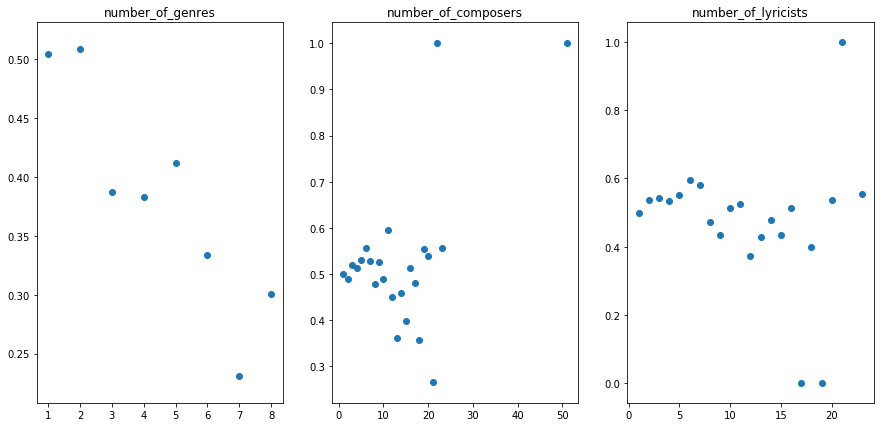

In [60]:
df_lis = [df_genres, df_composers, df_lyricists]
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 7))
for ax, df in zip(axes, df_lis):
    x = df.iloc[:,0].values
    y = df['mean'].values
    ax.scatter(x, y)
    ax.set(title = df.columns[0])
plt.show()


한 곡의 장르 수, 작곡가 수, 작사가 수 에 따라 사람들이 그 곡을 1달 이내에 다시 들는지에 대한 평군값이 어떻게 변하는지 그래프로 확인을 해보았습니다. 그 결과, 노래가 포함되는 장르의 수가 많아질 수록 그 노래를 1달 이내에 다시 들을 확률(평균값)이 내려가는 것을 알 수 있습니다.

1. number of genres = target의 값과 부정적인 선형관계
2. numver of composers = 관계 없음 (부정확)
3. numver of composers = 관계 없음

In [61]:
lis1 = ['genre_ids', 'lyricist', 'composer', 'artist_name', 'language']
for x in lis1:
    print(x, ':', len(train_songs_copy[x].unique()))


genre_ids : 573
lyricist : 33876
composer : 76035
artist_name : 40571
language : 11


In [62]:
train_songs = pd.read_pickle('train_songs')
train_songs_copy = train_songs.copy()

In [63]:
def top10(df, x):
    df = df[[x, 'target']]
    df1 = df.groupby(x).size().sort_values(ascending=False)
    df2 = df1.reset_index()
    df2.columns = [x, 'count']
    df3 = list(df2.iloc[0:10, 0])
    return df3

In [64]:
def subcategory_graph(col, names, base_val, nrows, ncols):

    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20, 15))

    for ax, name in zip(axes.flat, names):
        df = train_songs_copy[train_songs_copy[col] == name]
        df1 = df[[base_val, 'target']].groupby([base_val]).agg(['mean', 'count'])
        df1 = df1.reset_index()
        df1.columns = [base_val, 'mean', 'count']
        x = df1['count'].values
        y = df1['mean'].values
        ax.scatter(x, y)
        ax.set(title = name)
        plt.tight_layout()
    plt.show()

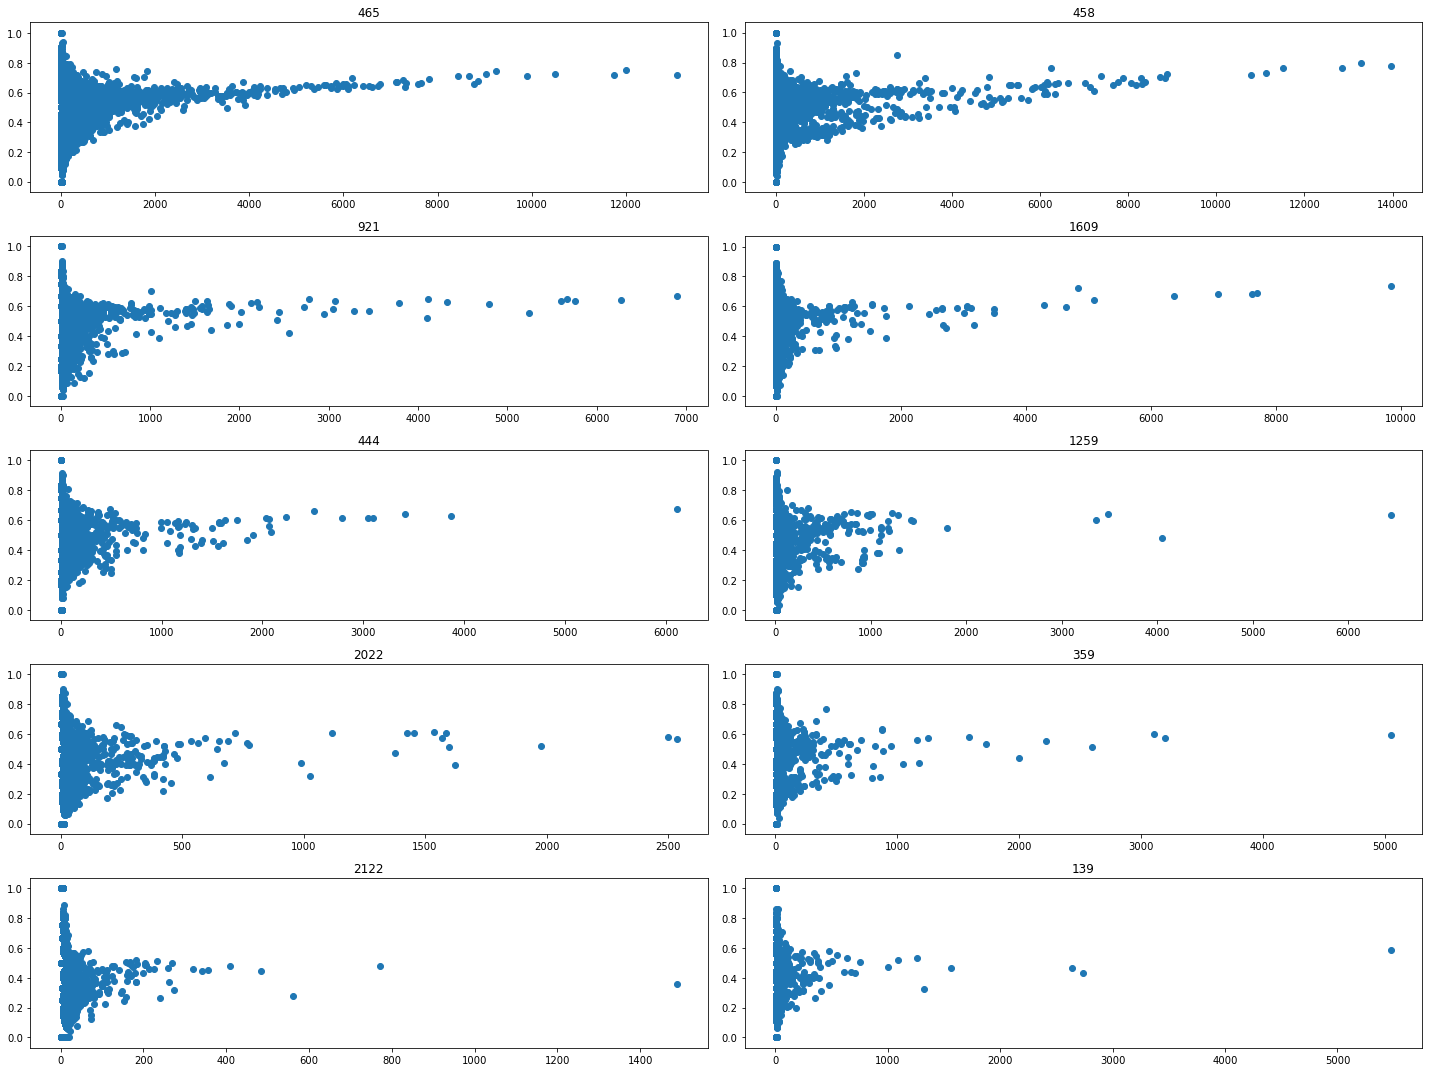

In [65]:
subcategory_graph(col = 'genre_ids', names = top10(train_songs_copy, 'genre_ids'), base_val='song_id', nrows = 5, ncols = 2)

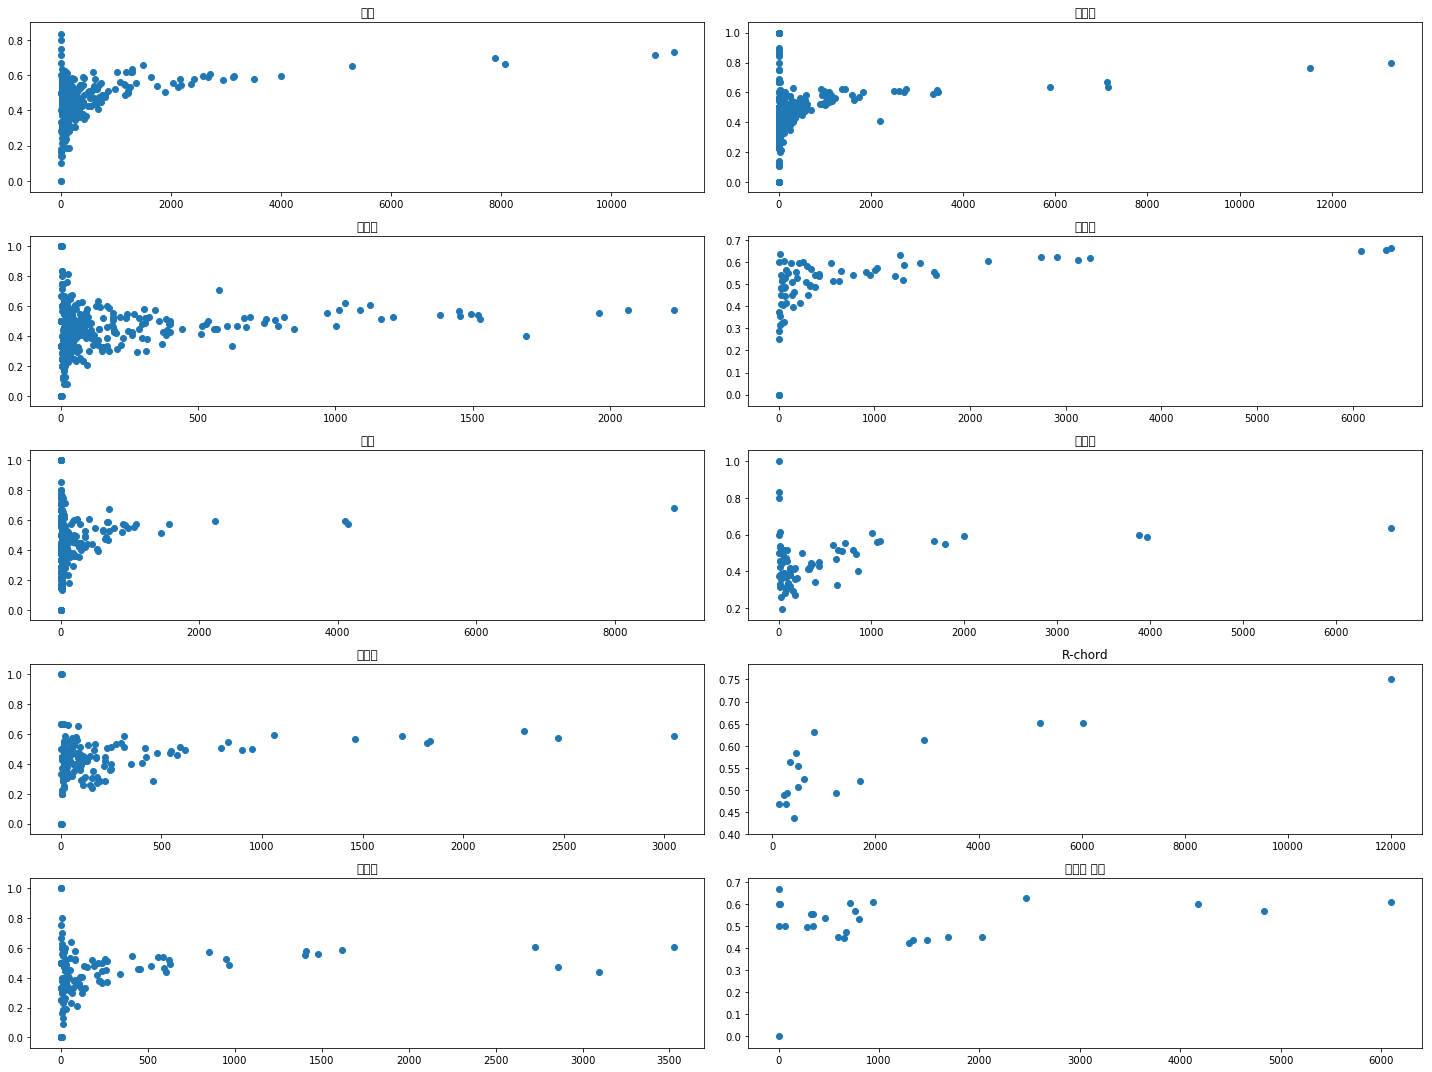

In [66]:
subcategory_graph(col = 'lyricist', names = top10(train_songs_copy, 'lyricist'), base_val='song_id',nrows = 5, ncols = 2)

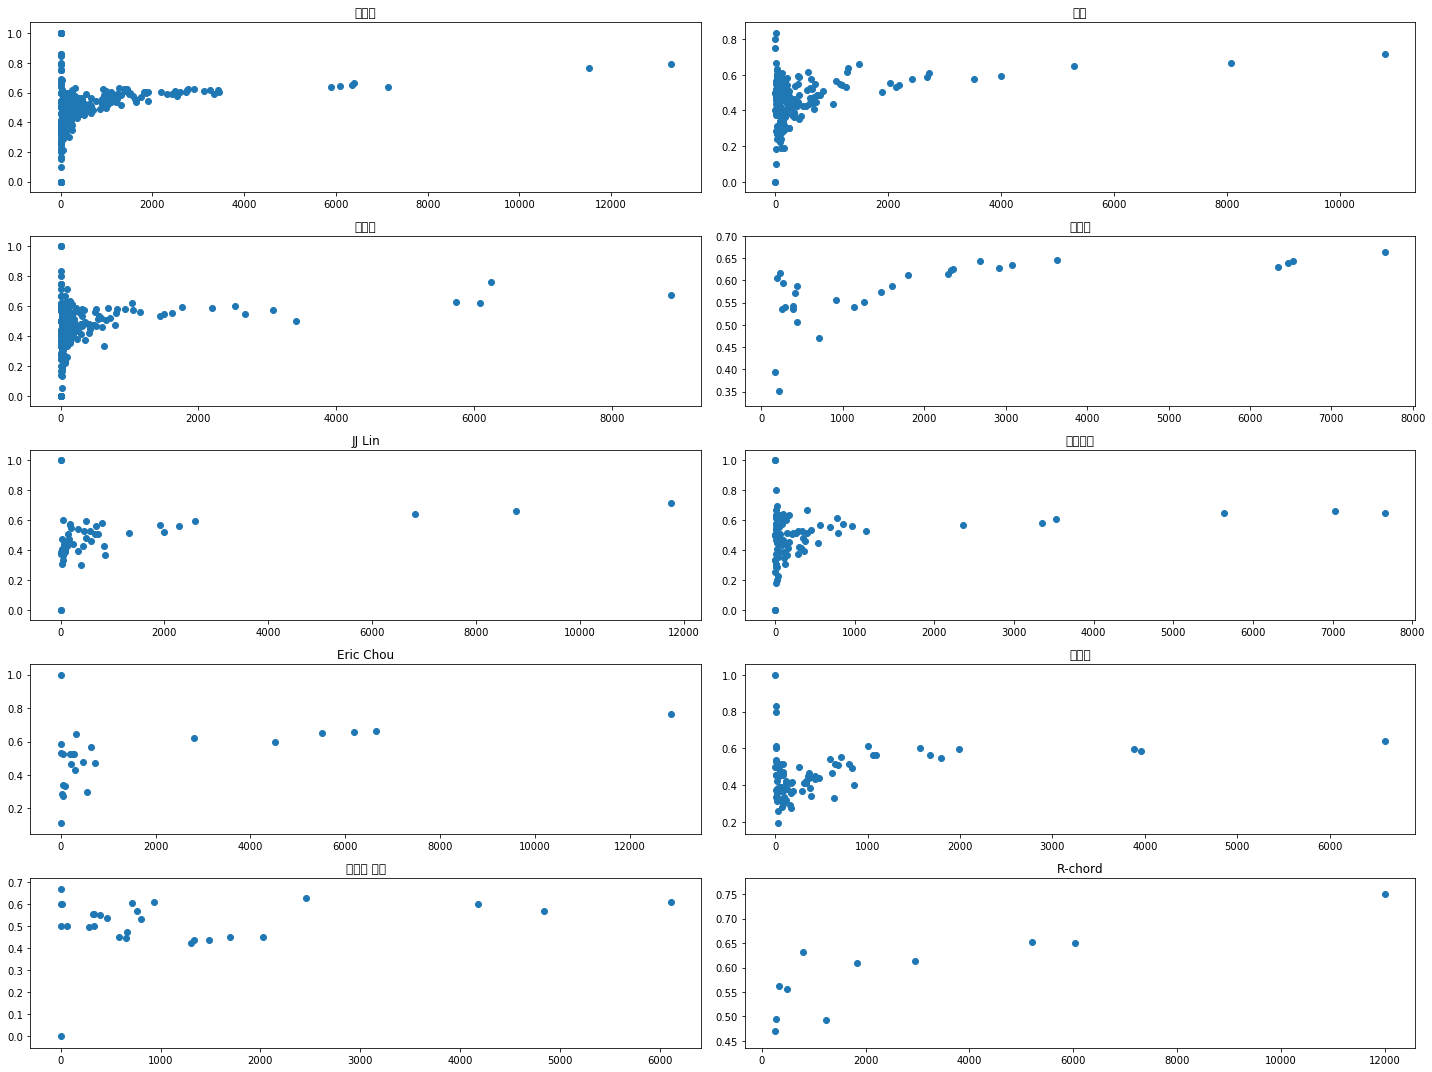

In [67]:
subcategory_graph(col = 'composer', names = top10(train_songs_copy, 'composer'),base_val='song_id', nrows = 5, ncols = 2)

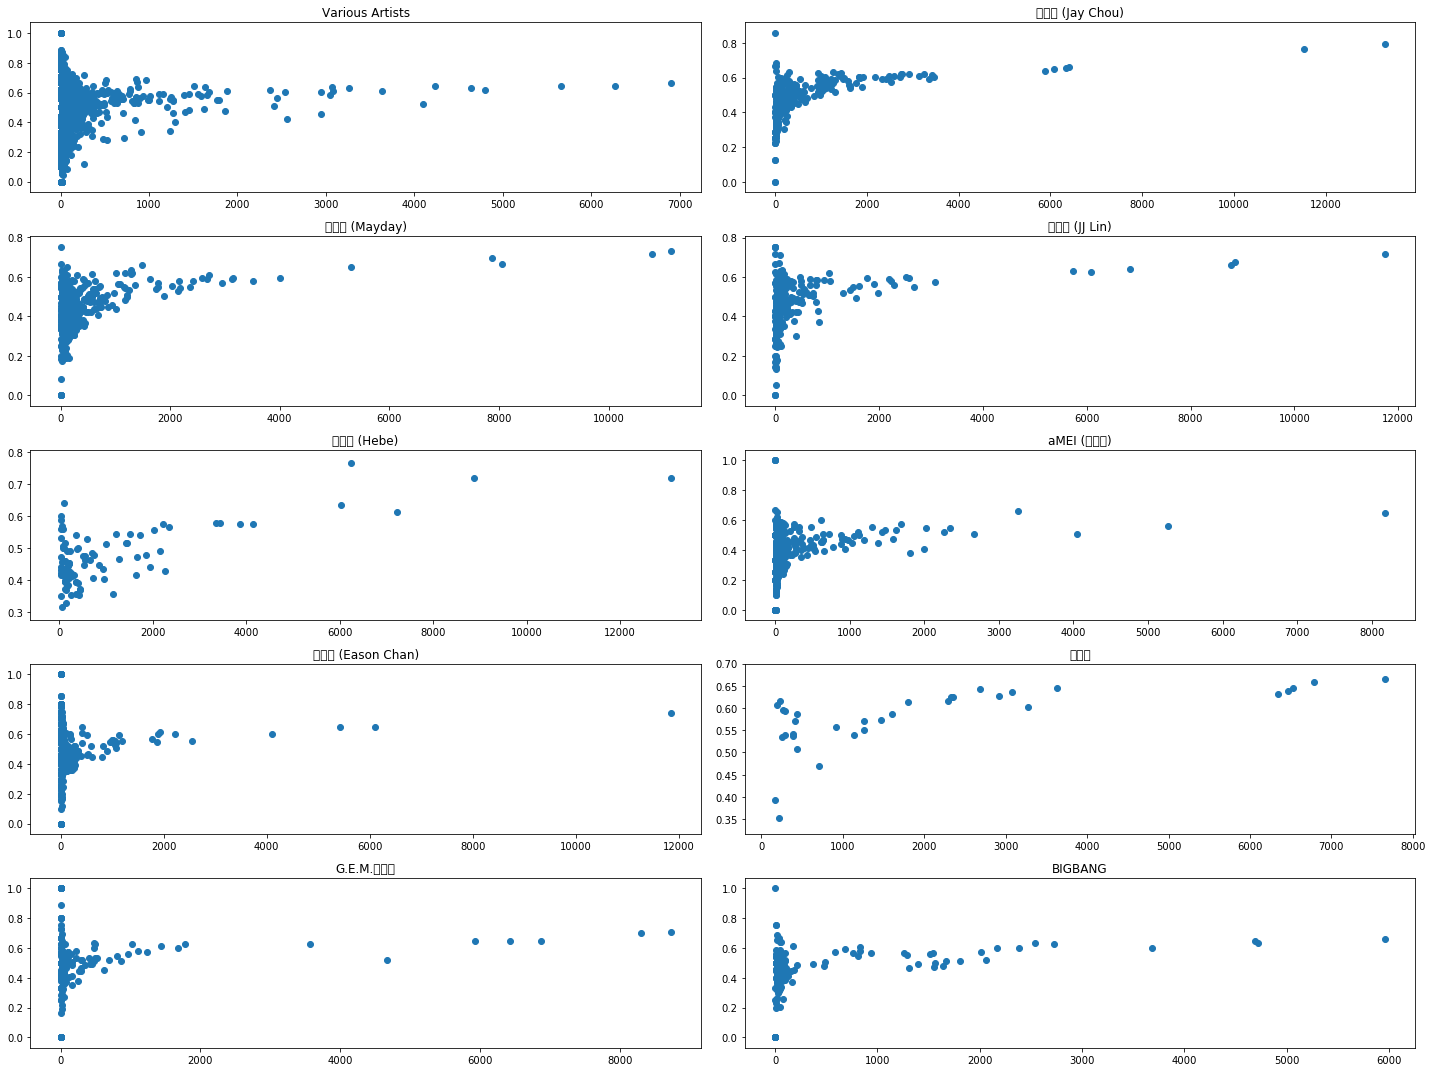

In [68]:
subcategory_graph(col = 'artist_name', names = top10(train_songs_copy, 'artist_name'),base_val='song_id', nrows = 5, ncols = 2)

각 변수들 의 값 들중, 가장 많이 train 데티어 세트에  나오는 값 10개를 찾아, 각각의 값에 해당되는 데이터(작곡가의 경우, 그 작곡가가 작곡한 노래 및 target 값)로 서브그룹을 만든 후, target의 평균값과 각 값에 대응하는 노래가 몇개 있는지에 대한 관계(예를 들어 작곡가 A씨가 자곡한 곡 이 몇 개 있는지)를 그래프로 표현해 보았습니다

결론 : 서브그룹으로 나눈 후  그래프를 보면 노래의 대중성과 평균값 사이에 긍정적인 관계가 있다는 것을 볼 수 있습니다.

In [69]:
def subcategory_graph2(col, names, base_val, nrows, ncols):

    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20, 15))

    for ax, name in zip(axes.flat, names):
        df = train_songs_copy[train_songs_copy[col] == name]
        df1 = df[[base_val, 'target']].groupby([base_val]).agg(['mean', 'count'])
        df1 = df1.reset_index()
        df1.columns = [base_val, 'mean', 'count']
        df1['repeat'] = df1['mean']*df1['count'] 
        
        x = []
        y = []
        for i in range(1,df1['count'].max()+1):
            plays_i = df1[df1['count']==i]
            count = plays_i['count'].sum()
            if count > 0:
                x.append(i)
                y.append(plays_i['repeat'].sum() / count)

        ax.scatter(x, y)
        ax.set(title = name)
        plt.tight_layout()
    plt.show()

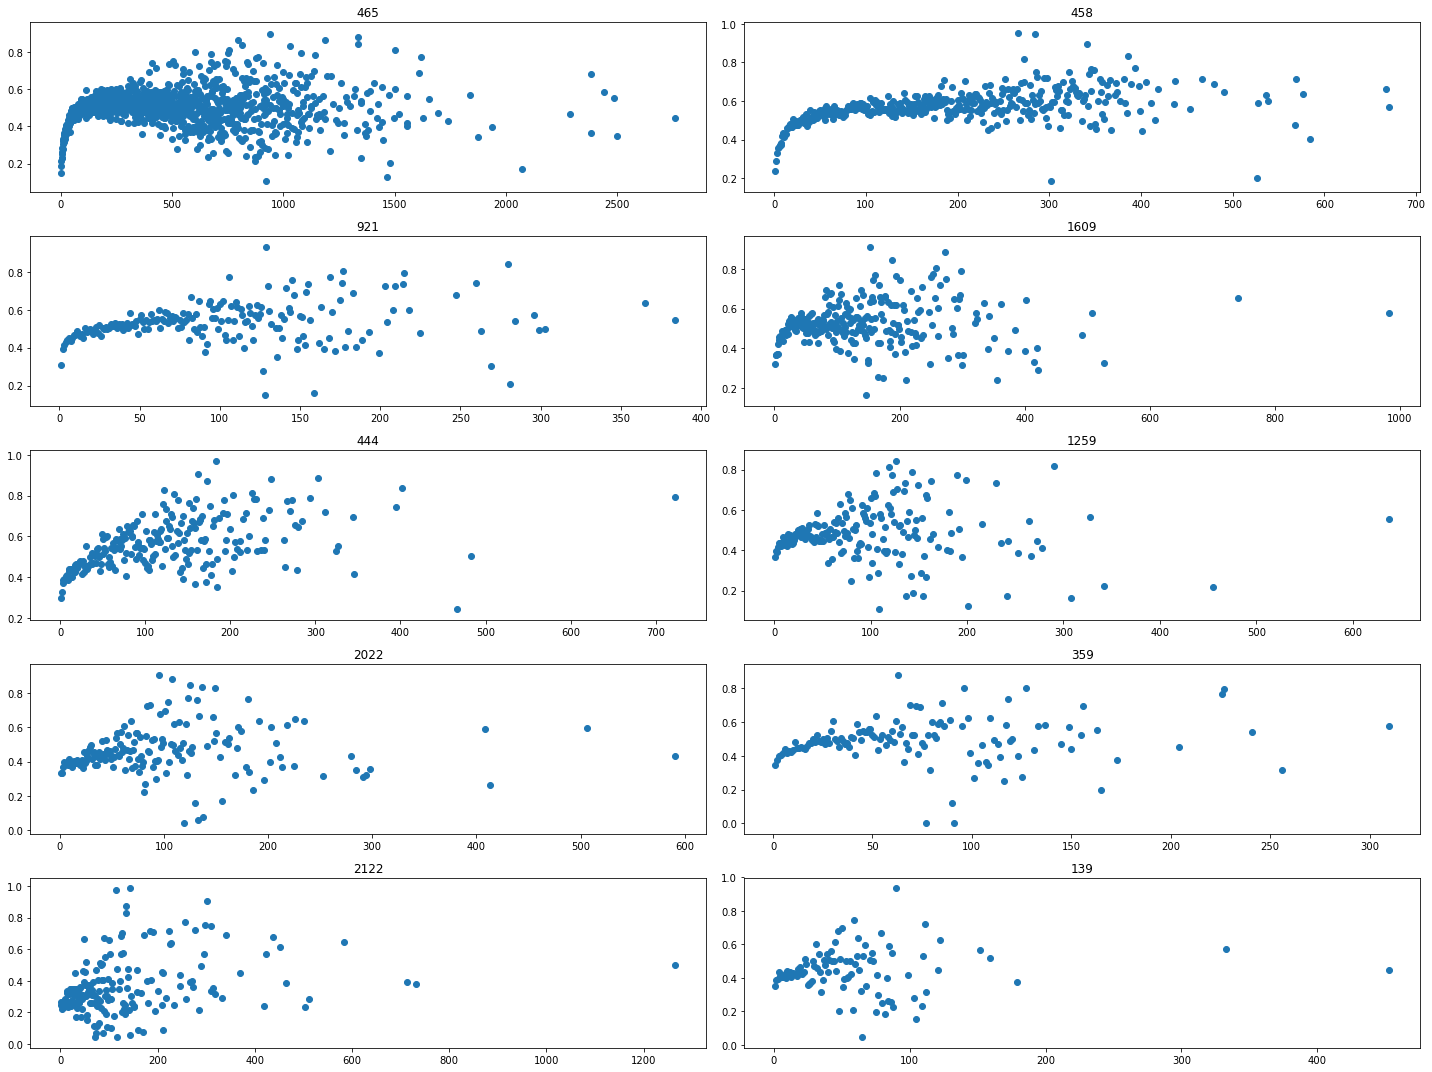

In [70]:
subcategory_graph2(col = 'genre_ids', names = top10(train_songs_copy, 'genre_ids'), base_val='msno', nrows = 5, ncols = 2)

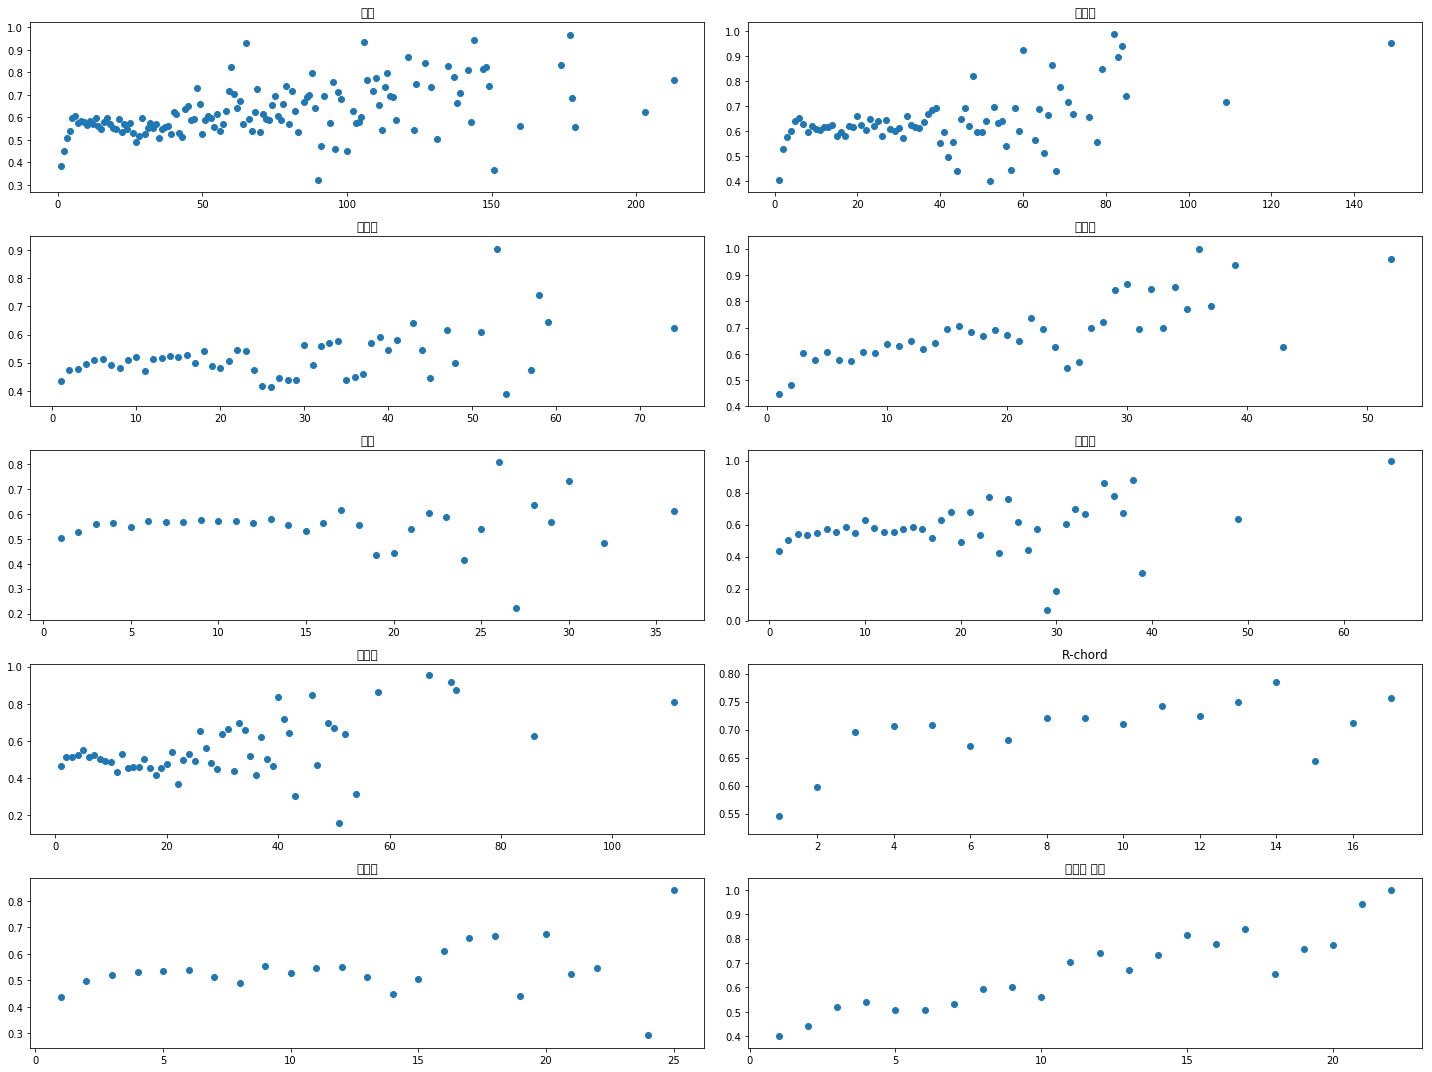

In [71]:
subcategory_graph2(col = 'lyricist', names = top10(train_songs_copy, 'lyricist'), base_val='msno', nrows = 5, ncols = 2)

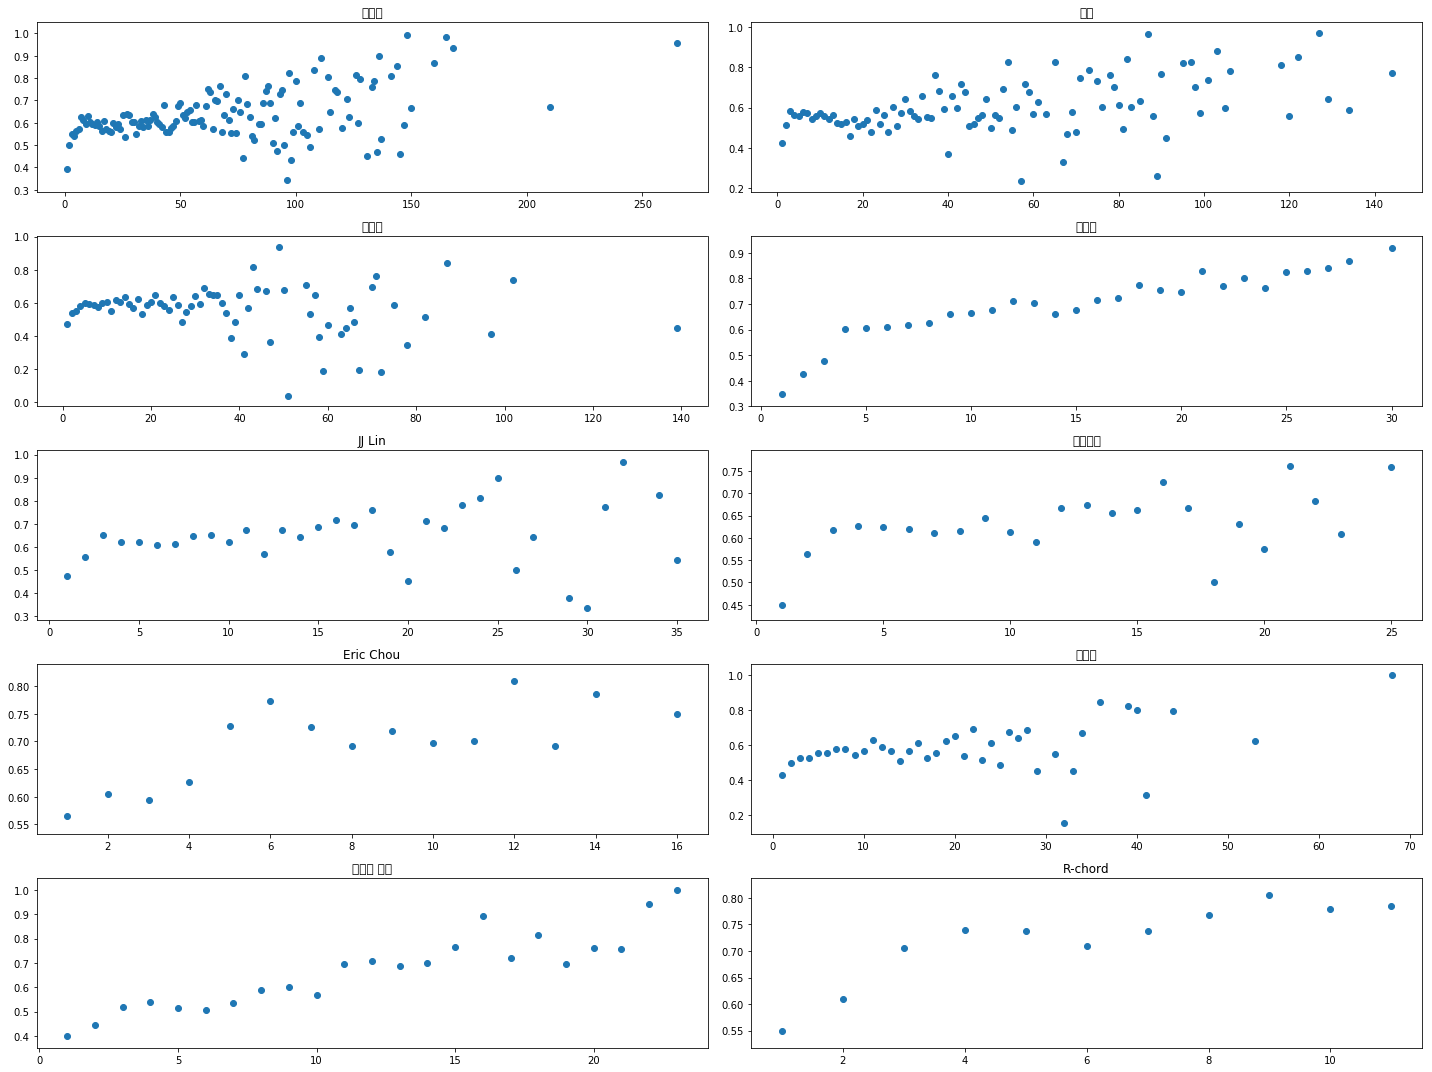

In [72]:
subcategory_graph2(col = 'composer', names = top10(train_songs_copy, 'composer'), base_val='msno', nrows = 5, ncols = 2)

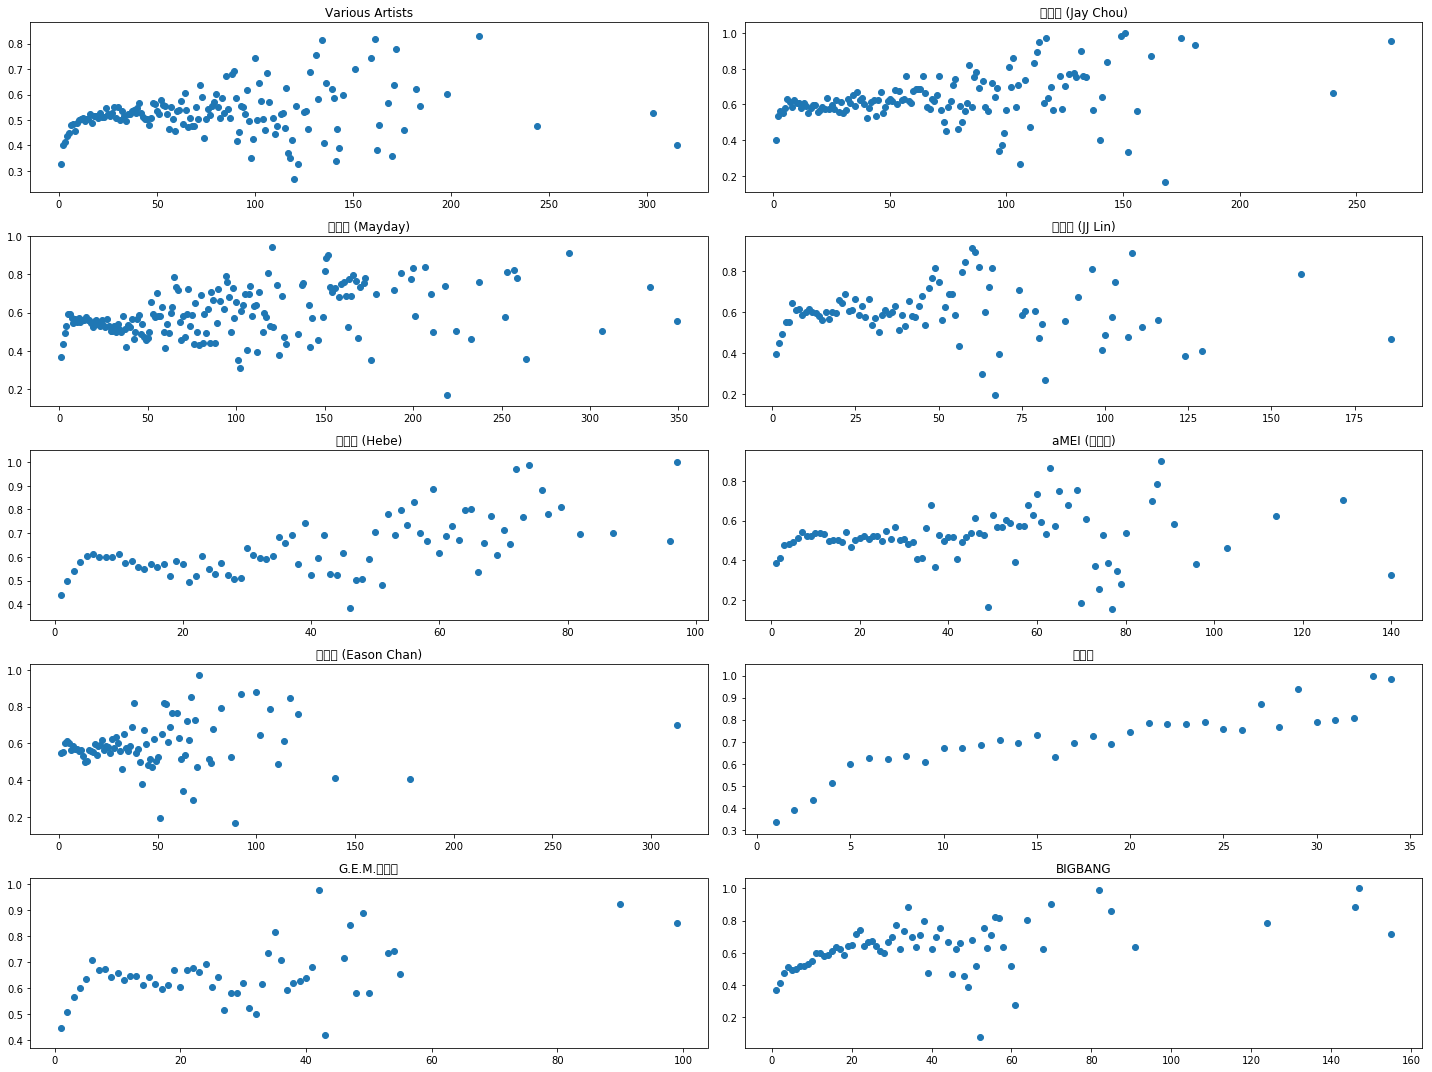

In [73]:
subcategory_graph2(col = 'artist_name', names = top10(train_songs_copy, 'artist_name'), base_val='msno', nrows = 5, ncols = 2)

각 변수들 의 값 들중, 가장 많이 train 데이터 세트에  나오는 값 10개를 찾아, 각각의 값에 해당되는 데이터(작곡가의 경우, 그 작곡가가 작곡한 노래를 들은 고객들과  target 값)로 서브그룹을 만든 후, target의 평균값과 사람들이 각 변수의 값에 해당하는 노래(작곡가의 경우, 그 작곡가가 작곡한 노래)를 몇 개나 들었는지 비교해 보았습니다.

아래의 그래프의 경우, 각 X 값에 해당하는 Y 값이 너무 많아 기존 scatter plot 으로는 관계성을 확인하기 어려워, 한 X 값에 해당하는 Y값들을 전부 그래프에 표현하지 않고 해당 X에 대한 Y의 평균 값만 그래프에 나타내었습니다 

**결론** 
1. genre_ids : 노래 장르의 경우, 사람들이 한 장르에 해당하는 노래를 몇 번 이상 들으면은 (405에 해당하는 장르의 경우 대략 20번), 그 장르에 해당는 노래를 다시 들을 학률(평균 target 값)이 특정 값으로 수렴하다가 다시 분산되는 것을 볼 수 있습니다
2. lyricist : 작사가의 경우, 해당 작사가 노래를 더 많이 들을 수록 target 의 평균 값이 올라가는 것을 볼 수 있습니다
3. composer : 작곡가의 경우도 작사가와 같은 경향을 보입니다
4. artist_name : 가수의 경우도 작사가아 같은 경향을 보입니다


In [74]:
train_songs.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'name', 'isrc'],
      dtype='object')

In [75]:
df = train_songs[['source_screen_name', 'target']]. groupby('source_screen_name').size().sort_values(ascending=False)
print('number of unique values : ', len(df))
print(df)

number of unique values :  20
source_screen_name
Local playlist more     3227751
Online playlist more    1294324
Radio                    474316
Album more               419987
Search                   298415
Artist more              252403
Discover Feature         244181
Discover Chart           213637
Others profile more      201772
Discover Genre            82130
My library                75970
Explore                   72311
Unknown                   54160
Discover New              15955
Search Trends             13632
Search Home               13482
My library_Search          6451
Self profile more           212
Concert                      47
Payment                      12
dtype: int64


In [76]:
df = train_songs[['source_type', 'target']]. groupby('source_type').size().sort_values(ascending=False)
print('number of unique values : ', len(df))
print(df)

number of unique values :  12
source_type
local-library             2261119
online-playlist           1967350
local-playlist            1079317
radio                      482954
album                      477144
top-hits-for-artist        423552
song                       244670
song-based-playlist        210500
listen-with                192818
topic-article-playlist      11190
artist                       3037
my-daily-playlist             663
dtype: int64


In [77]:
df = train_songs[['source_system_tab', 'target']]. groupby('source_system_tab').size().sort_values(ascending=False)
print('number of unique values : ', len(df))
print(df)

number of unique values :  9
source_system_tab
my library      3684155
discover        2178698
search           623096
radio            476550
listen with      212242
explore          167882
null               6477
notification       6183
settings           2200
dtype: int64


In [78]:
def categorical_variable_graph(df, val_name, val_num, title):
    df1 = df[[val_name, 'target']]. groupby(val_name).agg(['mean', 'count'])
    df1 = df1.reset_index()
    df1.columns = [val_name, 'mean', 'count']
    x = list(df1[val_name])
    y = df1['mean'].values
    
    fig, ax = plt.subplots(figsize = (25, 7))

    ind = range(1,val_num)

    plt.bar(ind, y)
    ax.set_xticks(ind)
    ax.set_xticklabels(x)

    ax.set_ylabel('Mean target value')
    ax.set_title(title)
    plt.show()

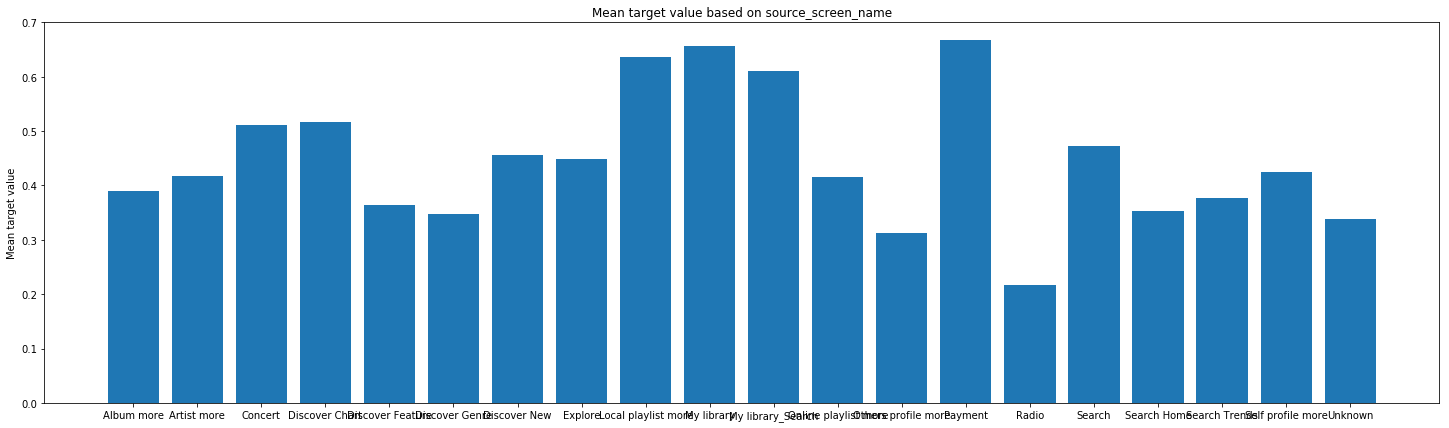

In [79]:
categorical_variable_graph(df = train_songs,val_name = 'source_screen_name', val_num = 21, title = 'Mean target value based on source_screen_name')

Source_scree_name 의 값에 따라서 평균 target 값이 크게 달라지는 것을 알 수 있습니다

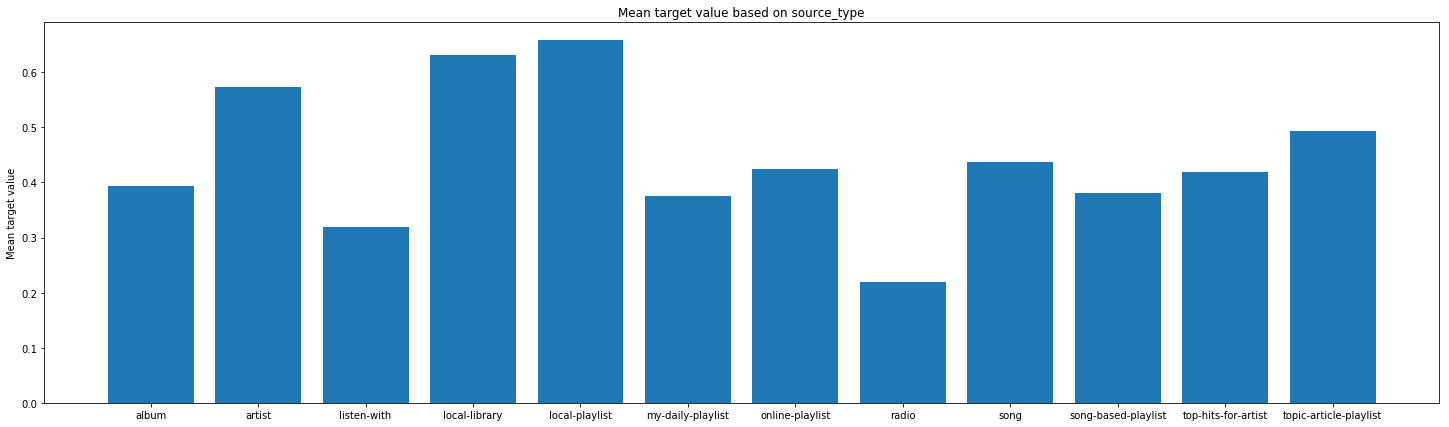

In [80]:
categorical_variable_graph(df = train_songs, val_name = 'source_type', val_num = 13, title = 'Mean target value based on source_type')

Source_type 의 값에 따라서 평균 target 값이 크게 달라지는 것을 알 수 있습니다

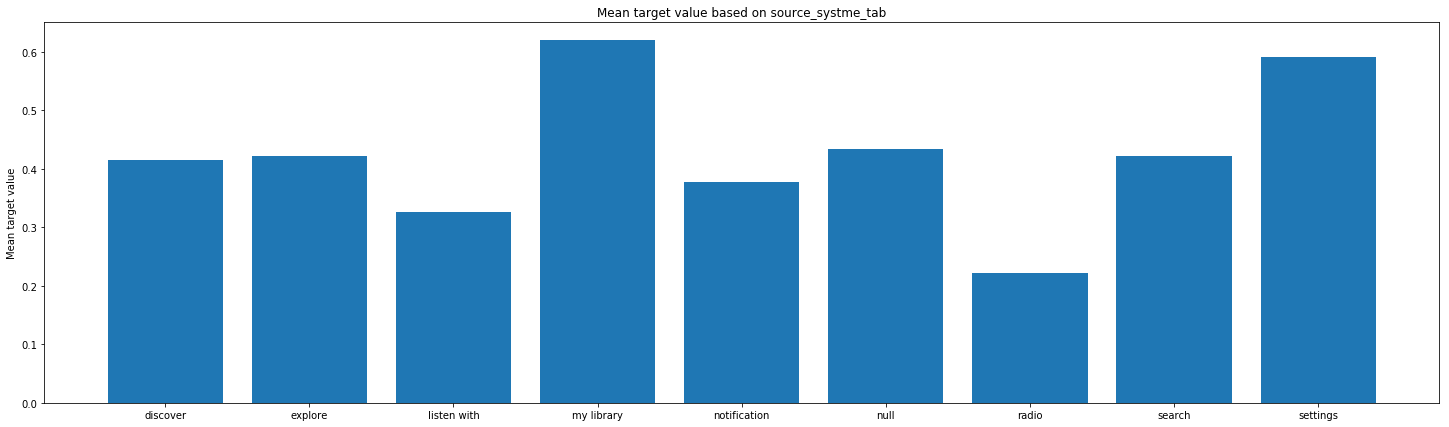

In [81]:
categorical_variable_graph(df = train_songs, val_name = 'source_system_tab', val_num = 10, title = 'Mean target value based on source_systme_tab')

source_system_tab 의 값에 따라서 평균 target 값이 크게 달라지는 것을 알 수 있습니다

### 3. train 데이터와 member 데이터 세트를 통한 분석

In [34]:
for x in list(members.columns):
    print('number of unique values(%s) :' %x,  len(set(members[x])))

number of unique values(msno) : 34403
number of unique values(city) : 21
number of unique values(bd) : 95
number of unique values(gender) : 3
number of unique values(registered_via) : 6
number of unique values(registration_init_time) : 3862
number of unique values(expiration_date) : 1484


In [3]:
train_members = pd.merge(train, members, on = 'msno')

In [4]:
train_members['membership_days'] = (train_members['expiration_date'] - train_members['registration_init_time']).dt.days.astype(int)
train_members = train_members.drop(['registration_init_time','expiration_date'], axis=1)

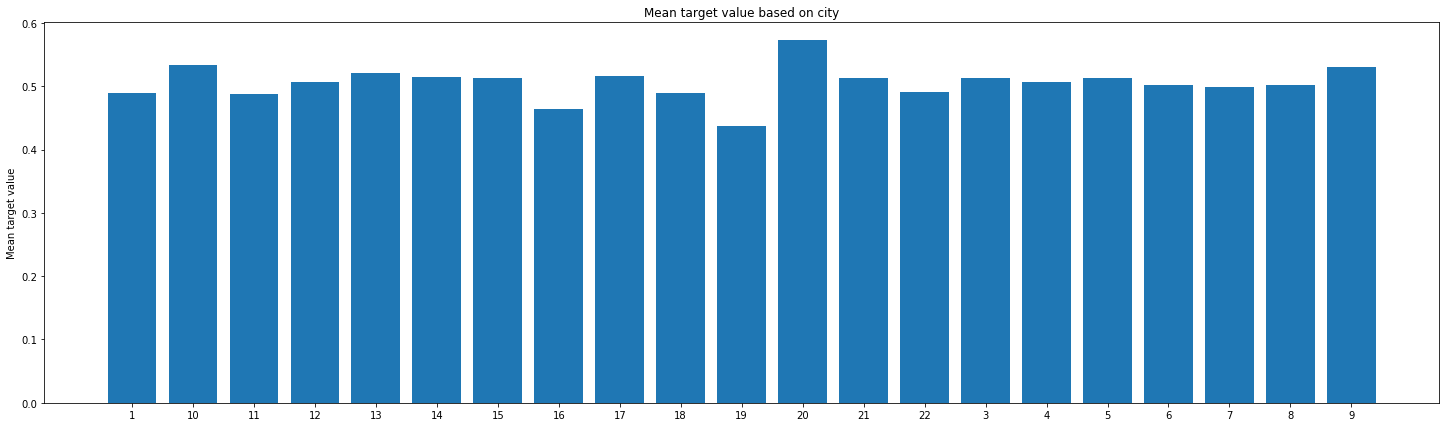

In [6]:
categorical_variable_graph(df = train_members, val_name = 'city', val_num = 22, title = 'Mean target value based on city')

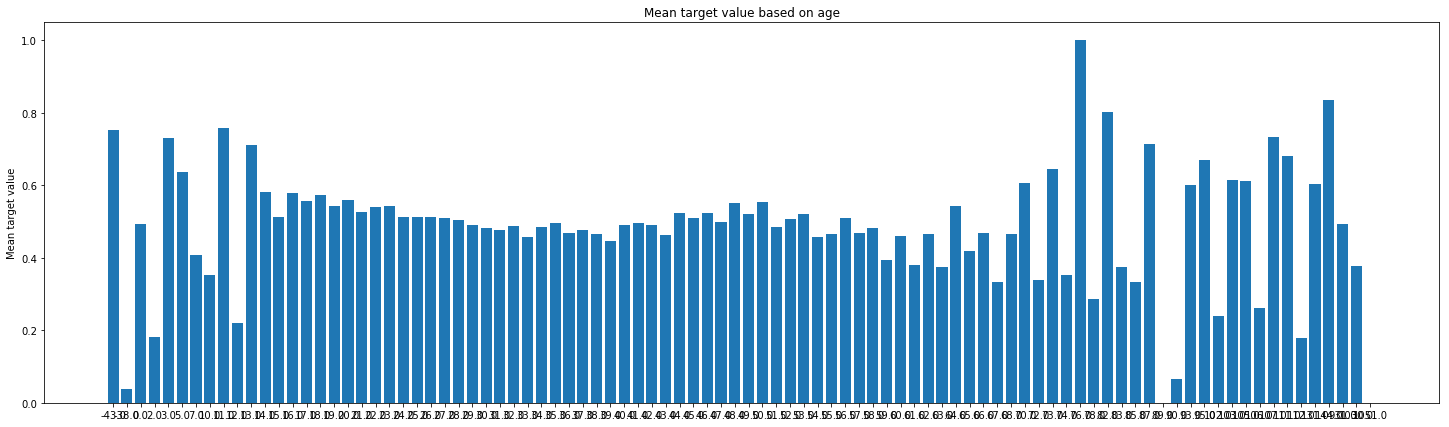

In [14]:
categorical_variable_graph(df = train_members, val_name = 'bd', val_num = 93, title = 'Mean target value based on age')

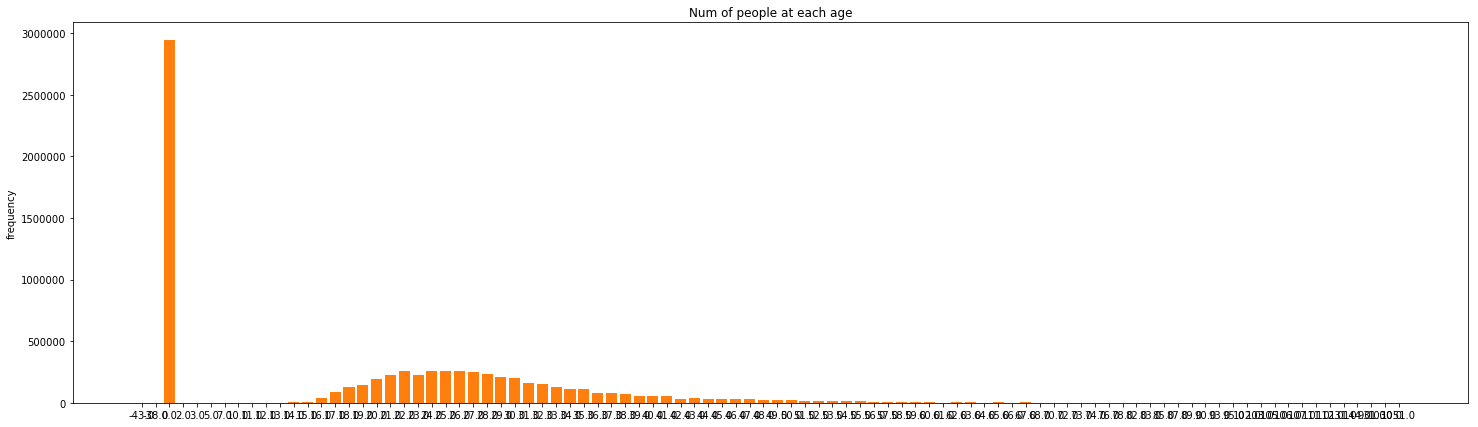

In [29]:
df_age = train_members.groupby(['bd']).size()
df_age1 = df_age.reset_index()
df_age1.columns = ['age', 'frequency']
df_age1 = df_age1.sort_values(by = ['age'])


fig, ax = plt.subplots(figsize = (25, 7))

x = list(df_age1['age'])
y = df_age1['frequency'].values

ind = range(1,len(df_age1)+1)
plt.bar(ind, y)
ax.set_xticks(ind)
ax.set_xticklabels(x)

plt.bar(ind, y)

ax.set_ylabel('frequency')
ax.set_title('Num of people at each age')
plt.show()

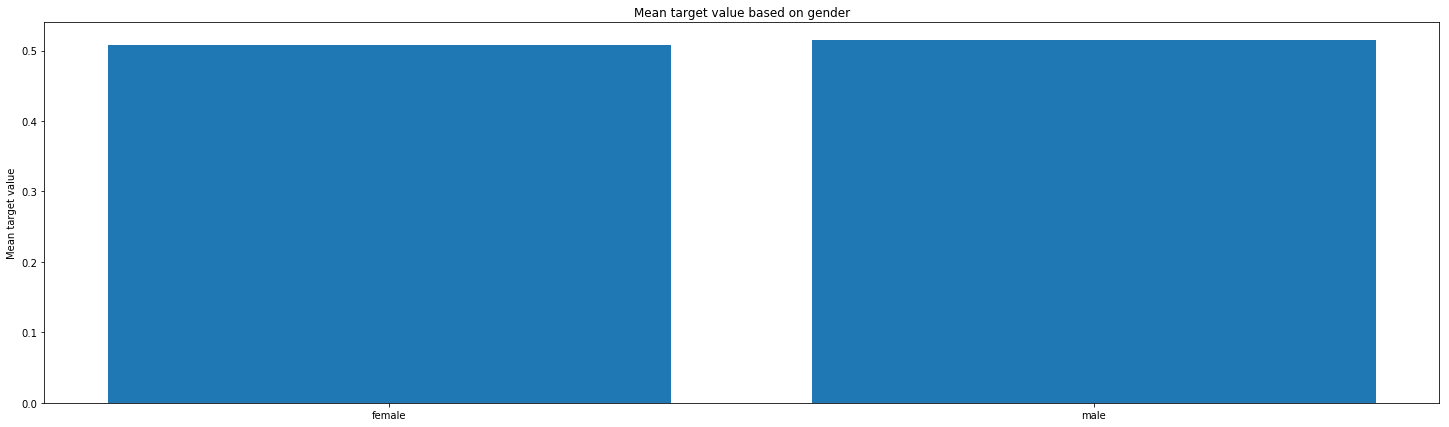

In [10]:
categorical_variable_graph(df = train_members, val_name = 'gender', val_num = 3, title = 'Mean target value based on gender')

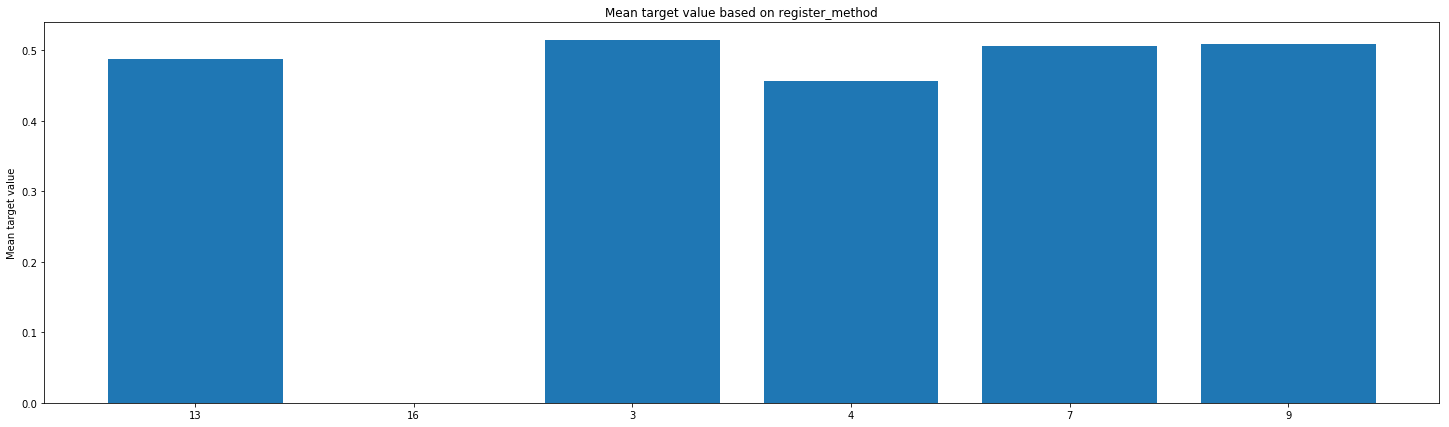

In [15]:
categorical_variable_graph(df = train_members, val_name = 'registered_via', val_num = 7, title = 'Mean target value based on register_method')

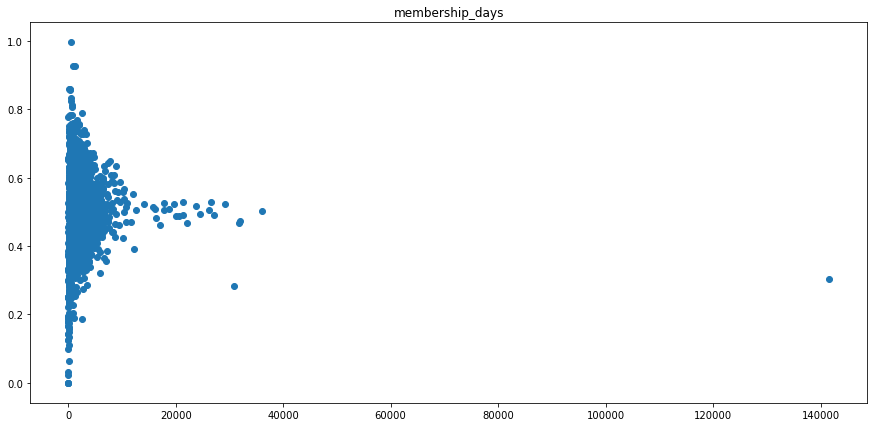

In [21]:
num_days = index_reset2(mean_count2(train_members, 'membership_days'), 'membership_days')
num_days['repeat'] = num_days['mean']*num_days['count'] 

fig, ax = plt.subplots(figsize=(15, 7))

x = []
y = []
for i in range(1,num_days['count'].max()+1):
    plays_i = num_days[num_days['count']==i]
    count = plays_i['count'].sum()
    if count > 0:
        x.append(i)
        y.append(plays_i['repeat'].sum() / count)

ax.scatter(x, y)
ax.set(title = num_days.columns[0])
plt.show()

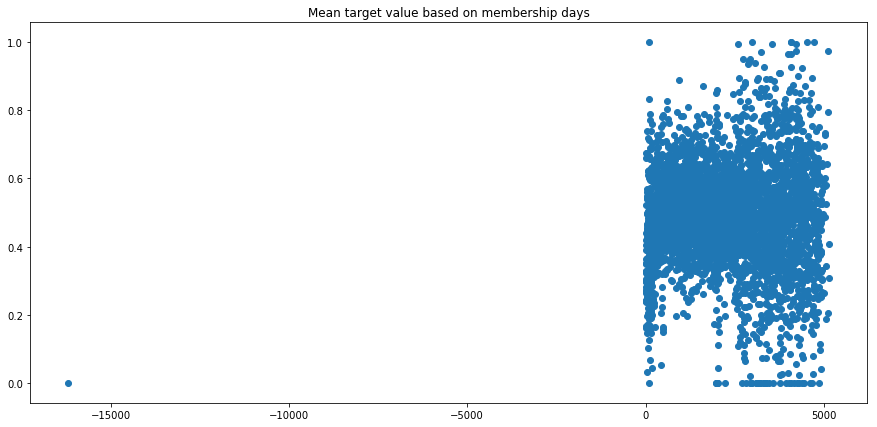

In [24]:
num_days.sort_values(by=['membership_days'])
x = num_days['membership_days'].values
y = num_days['mean'].values

fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(x, y)
ax.set(title= 'Mean target value based on membership days')
plt.show()